In [3]:
from numpy.core.numeric import True_
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from torchvision import transforms

dataset = "mnist"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_epochs = 50
num_samples = 100
colab = False
results_path = "/l/vision/magnezone_ssd/ziweizhao/c2c_vae_cfe/results"
train_oracle = False
train_vae = False
train_c2c_vae = False

In [7]:
from torchvision.datasets import MNIST
batch_size = 100
train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

data_path = '/content/gdrive/My Drive/datasets/mnist' if colab else '/l/vision/magnezone_ssd/ziweizhao/dataset/mnist'

train_dataset = MNIST(root=data_path, download=True, train=True, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root=data_path, download=True, train=False, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [8]:
def eval_mnist(model, dataloader):
    model.eval()
    correct = 0
    count = 0
    for image, label in dataloader:
        with torch.no_grad():
            output = model(image.to(device))
            label = label.to(device)

            correct += torch.sum(torch.argmax(output, axis=1)==label)
            count += label.size(0)
    
    return (correct.item()/count)



In [9]:
#The classifier to be explained
oracle = torchvision.models.resnet18(pretrained=False)
oracle.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
oracle.fc = nn.Linear(in_features=512, out_features=10, bias=True)

if train_oracle == False:
    filename = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_oracle.pth'
    oracle.load_state_dict(torch.load(filename))
    oracle = oracle.to(device)
    oracle.eval()
else:
    oracle = oracle.to(device)
    num_batches = len(train_dataloader)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(oracle.parameters(), lr=1e-3, momentum=0.9)
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        total_loss = 0
        oracle.train()

        progress = tqdm(enumerate(train_dataloader), desc="Loss: ", total=num_batches)

        for i, data in progress:
            image, label = data[0].to(device), data[1].to(device)

            outputs = oracle(image)
            loss = loss_fn(outputs, label)
            oracle.zero_grad()
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            total_loss += current_loss

            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

        accuracy = eval_mnist(oracle, test_dataloader)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model_name = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_oracle.pth'
            torch.save(oracle.state_dict(), model_name)
        
print (eval_mnist(oracle, test_dataloader))

0.9901


In [10]:
latent_dims = 32
capacity = 64
variational_beta = 1

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


In [12]:
def eval_vae(vae, dataloader):
    vae.eval()

    test_loss_avg, num_batches = 0, 0
    for image_batch, _ in dataloader:

        with torch.no_grad():

            image_batch = image_batch.to(device)
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            test_loss_avg += loss.item()
            num_batches += 1

    test_loss_avg /= num_batches
    return (test_loss_avg)

In [13]:
vae = VariationalAutoencoder()
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)

if train_vae == False:   
    filename = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_vae_'+str(variational_beta)+'.pth'
    vae.load_state_dict(torch.load(filename) )
    print('done')
    
else:
    train_loss_avg = []
    best_val_loss = 1e10
    print('Training vae ...')
    for epoch in range(num_epochs):
        vae.train()
        train_loss_avg.append(0)
        num_batches = 0
    
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

        val_loss = eval_vae(vae, test_dataloader)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_vae_'+str(variational_beta)+'.pth'
            torch.save(vae.state_dict(), model_name)
            print("new best val loss {}, saving model".format(val_loss))

done


In [14]:
vae.eval()

sample_count = np.zeros(10)
tensor_sum = torch.zeros([10,latent_dims])
for image_batch, labels in train_dataloader:
    i = 0
    with torch.no_grad():
    
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        for j in range(labels.size()[0]):
            j = labels[j].item()
            sample_count[j] += 1
            tensor_sum[j,:] += latent_mu[i,:].detach().cpu()

            i += 1

prototype_mus = torch.zeros([10,latent_dims])
prototypes = torch.Tensor(10,1,28,28)

for i in range(10):
    prototype_mus[i,:] = tensor_sum[i,:]/sample_count[i]
    prototypes[i,:,:,:] = vae.decoder(prototype_mus[i,:].unsqueeze(0).to(device))

In [15]:
c2c_latent_dims = 10
c2c_capacity = 32
c2c_variational_beta = 1
label_size = 10

In [16]:
class c2c_Encoder(nn.Module):
    def __init__(self):
        super(c2c_Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_dims + label_size*2, out_features=c2c_capacity)
        self.fc_mu = nn.Linear(in_features=c2c_capacity, out_features=c2c_latent_dims)
        self.fc_logvar = nn.Linear(in_features=c2c_capacity, out_features=c2c_latent_dims)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class c2c_Decoder(nn.Module):
    def __init__(self):
        super(c2c_Decoder, self).__init__()
        self.fc2 = nn.Linear(in_features=c2c_latent_dims + label_size*2, out_features=c2c_capacity)
        self.fc1 = nn.Linear(in_features=c2c_capacity, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc2(x)
        x = self.fc1(x)
        return x
    
class c2c_VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(c2c_VariationalAutoencoder, self).__init__()
        self.encoder = c2c_Encoder()
        self.decoder = c2c_Decoder()
    
    def forward(self, x):
        x,label = torch.split(x,(latent_dims,label_size*2),dim = 1)
        c2c_latent_mu, c2c_latent_logvar = self.encoder(torch.cat((x,label), dim=1))
        c2c_latent = self.latent_sample(c2c_latent_mu, c2c_latent_logvar)
        x_recon = self.decoder(torch.cat((c2c_latent,label), dim=1))
        return x_recon, c2c_latent_mu, c2c_latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def c2c_vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x.view(-1, latent_dims), x.view(-1, latent_dims), reduction='sum')
    
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + c2c_variational_beta * kldivergence
    


In [17]:
c2c_vae = c2c_VariationalAutoencoder()
c2c_vae = c2c_vae.to(device)

optimizer = torch.optim.Adam(params=c2c_vae.parameters(), lr=1e-3, weight_decay=1e-5)
vae.eval()
train_loss_avg = []
if train_c2c_vae == False:
    filename = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_c2c_vae_'+str(c2c_variational_beta)+'.pth'
    c2c_vae.load_state_dict(torch.load(filename))
    c2c_vae.eval()
    print('done')

else:
    best_val_loss = 1e10
    print('Training ...')
    for epoch in range(num_epochs):
        c2c_vae.train()
        train_loss_avg.append(0)
        num_batches = 0

        for i in range(100):
            images1, labels1 = iter(train_dataloader).next()
            images2, labels2 = iter(train_dataloader).next()
            images1 = images1.to(device)
            image_batch_recon1, latent_mu1, latent_logvar1 = vae(images1)
            images2 = images2.to(device)
            image_batch_recon2, latent_mu2, latent_logvar2 = vae(images2)       
            latent_diff = latent_mu1 - latent_mu2 
            label_diff = torch.cat((F.one_hot(labels1, num_classes=label_size),F.one_hot(labels2, num_classes=label_size)), dim=1)

            latent_diff = latent_diff.to(device)
            label_diff = label_diff.float().to(device)
            c2c_input = torch.cat((latent_diff,label_diff), dim=1)
            c2c_input = c2c_input.to(device)
            c2c_recon, c2c_latent_mu, c2c_latent_logvar = c2c_vae(c2c_input)
            loss = c2c_vae_loss(c2c_recon, latent_diff.detach(), c2c_latent_mu, c2c_latent_logvar)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        val_loss = eval_c2c_vae(c2c_vae, vae, test_dataloader)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = '/l/vision/magnezone_ssd/ziweizhao/c2c_vae/models/'+dataset+'_c2c_vae_'+str(c2c_variational_beta)+'.pth'
            torch.save(c2c_vae.state_dict(), model_name)
            print("new best val loss {}, saving model".format(val_loss))
        

done


In [21]:
def c2c_vae_cfe_v3(label1, label2, query, oracle):
    N_guides = 4
    c2c_vae.eval()
    label_diff = torch.cat((F.one_hot(torch.tensor([label1]), num_classes=label_size),F.one_hot(torch.tensor([label2]), num_classes=label_size)), dim=1)
    label_diff = label_diff.to(device)

    with torch.no_grad():
        _, latent_mu1, _ = vae(query.to(device))
    
    for i in range(1):
        flag = False
        latent_diffs = torch.empty(N_guides,10).normal_(mean=0,std=0.5).to(device)
        label_diff_repeated = label_diff.repeat(N_guides, 1)
        c2c_encoding = torch.cat((latent_diffs,label_diff_repeated.float()), dim=1)
        
        with torch.no_grad():
            c2c_recon = c2c_vae.decoder(c2c_encoding)
            recon_from_c2c_recon = vae.decoder(latent_mu1 - c2c_recon).cpu()
    
        queries = torch.cat([query]*N_guides,axis=0)
        diff = (recon_from_c2c_recon-queries)**2
        guide_idx = torch.argmin(torch.sum(torch.sum(diff,axis=2),axis=2))
        native_guide = recon_from_c2c_recon[guide_idx,:,:]
        guide_latent = (latent_mu1 - c2c_recon)[guide_idx]
        
        with torch.no_grad():
            _, latent_mu2, _ = vae(native_guide.to(device).unsqueeze(0))
            new_latent_mu = 0.5*latent_mu1 + 0.5*latent_mu2
            cfe = vae.decoder(new_latent_mu)
        inter_lambda = 0.5
    return (cfe[0].cpu(), native_guide.cpu(), inter_lambda, guide_latent, recon_from_c2c_recon)
    
    

In [19]:
digits = [[] for _ in range(10)]

for img_batch, label_batch in train_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 10000:
        break;

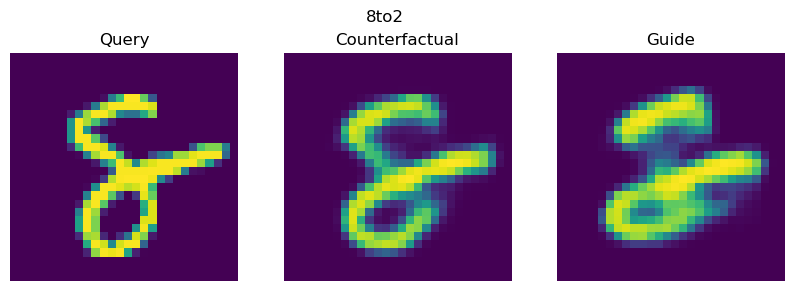

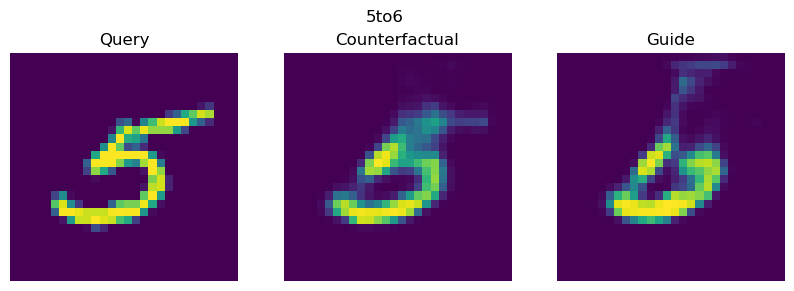

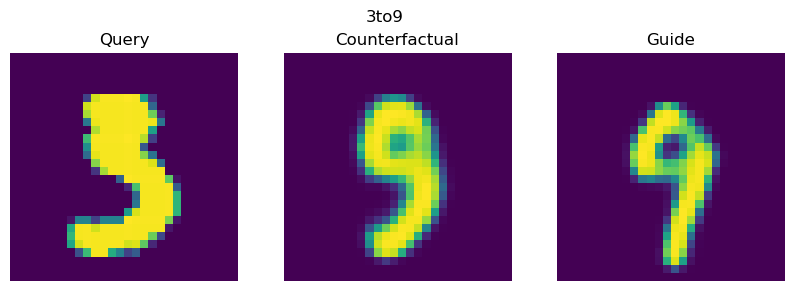

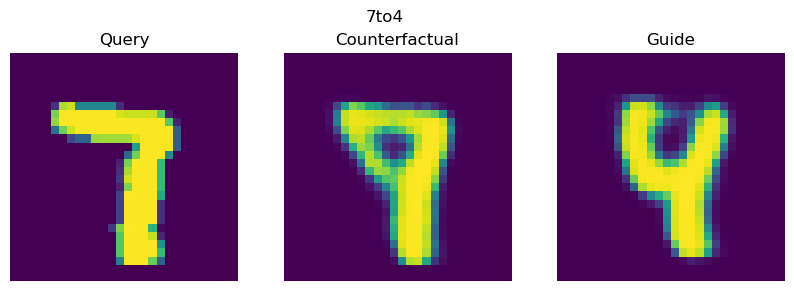

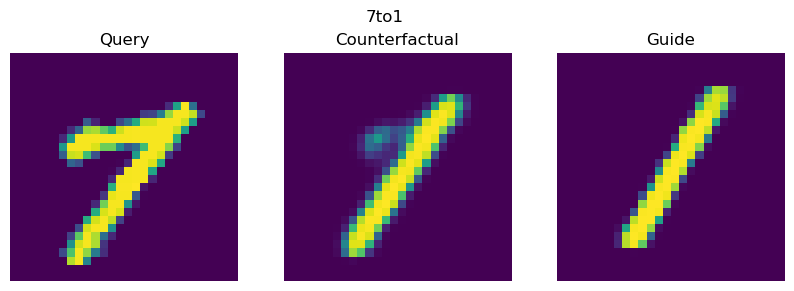

In [58]:
label1s = [8,5,3,7,7]
label2s = [2,6,9,4,1]

for i in range(5):
    label1 = label1s[i]
    label2 = label2s[i]
    query_img = torch.tensor(np.load("test"+str(i+1)+".npy"))
    #prediction = oracle(query_img.to(device))[0]
    #_, indices = torch.topk(prediction, 2)
    #if indices[0].item() == label1:
    #    label2 = indices[1].item()
    #else:
    #    label2 = indices[0].item()
    #label1 is query label, label2 is target label
            
    if (label1 == label2):
        print ("same label")
            #print (digits[label1][10][0,0,:,:])
    query = torch.clamp(query_img,0.0,1.0)
    cfe,guide,_,guide_latent,recon_from_c2c_recon = c2c_vae_cfe_v3(label1, label2, query, oracle)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10), dpi=100) #, sharex=True, sharey=True
    plt.axis('off')
    fig.suptitle(str(label1)+"to"+str(label2), y=0.66)
    ax[0].imshow(query[0].permute(1,2,0))
    ax[0].axis('off')
    ax[0].set_title('Query')
    ax[1].imshow(cfe.permute(1,2,0))
    ax[1].axis('off')
    ax[1].set_title('Counterfactual')
    ax[2].imshow(guide.permute(1,2,0))
    ax[2].axis('off')
    ax[2].set_title('Guide')        
